In [11]:
# Preparation
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=4, suppress=True)

In [14]:
def mktr(x, y):
    return np.array([[1, 0, x], [0, 1, y], [0, 0, 1]])


def mkrot(theta):
    return np.array(
        [
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1],
        ]
    )

def drawf(f, ax=None, name=None, wrong=False):
    """ Draw frame defined by f on axis ax (if provided) or on a new axis otherwise """
    xhat = f @ np.array([[0, 0, 1], [1, 0, 1]]).T
    yhat = f @ np.array([[0, 0, 1], [0, 1, 1]]).T
    if not ax:
        ax = plt.gca()
    ax.plot(xhat[0, :], xhat[1, :], "o-" if wrong else "r-")  # transformed x unit vector
    ax.plot(yhat[0, :], yhat[1, :], "y-" if wrong else "g-")  # transformed y unit vector
    if name:
        ax.text(xhat[0, 0], xhat[1, 0], name, va="top", ha="center")

@ipywidgets.interact(
    x=ipywidgets.FloatSlider(min=-2, max=+2, value=0),
    y=ipywidgets.FloatSlider(min=-2, max=+2, value=0),
    rot=ipywidgets.FloatSlider(min=-np.pi, max=np.pi, value=0),
)
def f(x, y, rot):
    _, ax = plt.subplots()
    plt.axis("equal")
    drawf(np.eye(3), ax, "world")
    drawf(mktr(x, y) @ mkrot(rot), ax)



interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [28]:
def fw_kinematics_wrong(theta1, theta2, l1=1.2, l2=1.5, end_offset=5):
    world = np.eye(3)
    world[1,0] = end_offset
    L1s = world @ mkrot(theta1)
    L1e = L1s @ mktr(l1,0)
    L2s = L1e @ mkrot(theta2)
    L2e = L2s @ mktr(l2, 0)
    return world, L1s, L1e, L2s, L2e


@ipywidgets.interact(
    theta1=ipywidgets.FloatSlider(min=-np.pi, max=+np.pi, value=0),
    theta2=ipywidgets.FloatSlider(min=-np.pi, max=+np.pi, value=0),
)
def draw(theta1, theta2):
    fig, ax = plt.subplots(figsize=(3, 3))
    plt.axis("equal")
    for f in fw_kinematics(theta1, theta2):  # This iterates over all frames
        drawf(f, ax)
    fig2, ax2 = plt.subplots(figsize=(3, 3))
    for f in fw_kinematics_wrong(theta1, theta2, end_offset = 1):  # This iterates over all frames
        drawf(f, ax2, wrong=True)
    
    ax.set(xlim=(-5, 5), ylim=(-5, 5))


interactive(children=(FloatSlider(value=0.0, description='theta1', max=3.141592653589793, min=-3.1415926535897…

# Assignments
## Assignment 1
- Will this approach work if the end frame of a link (e.g. L1e) is offset from the $x$ axis of the starting link?  Try it!

As we can see in the image above, the end frame of the L1 link is offset by 1 unit in the y-axis and all the calculations are being made regading the x-axis as defined by the start and end frame of the L1 link. Now, if it was to be done this way,  unless intentional, we would get some different results from expected because rotations and translations are being made using a different coordinate system upon each transformation. In other hand, if we were to consider the offset representation <b>without<b> changing the x-axis, e.g. the x-axis would still be a perpendicular to the y-axis going from left to right (as in standard way), then we would have to account for a translation in the y-axis to get the correct values. We could imagine a rigid link with a bent angle and perform 2 translations to get to the end frame, which equates to a translation with an angle.


- Build a robot arm with one revolute joint and one translational joint.

In [34]:
def fw_kinematics_new(theta1, trans1, l1=1, l2=1):
    world = np.eye(3)
    L1s = world @ mkrot(theta1)
    L1e = L1s @ mktr(l1,0)
    L2s = L1e
    L2e = L2s @ mktr(trans1, 0)
    return world, L1s, L1e, L2s, L2e

@ipywidgets.interact(
    theta1=ipywidgets.FloatSlider(min=-np.pi, max=+np.pi, value=0),
    trans1=ipywidgets.FloatSlider(min=0, max=3, value=0),
)
def draw(theta1, trans1):
    fig, ax = plt.subplots(figsize=(3, 3))
    plt.axis("equal")
    for f in fw_kinematics_new(theta1, trans1):  # This iterates over all frames
        drawf(f, ax)
    ax.set(xlim=(-5, 5), ylim=(-5, 5))

interactive(children=(FloatSlider(value=0.0, description='theta1', max=3.141592653589793, min=-3.1415926535897…

## Assignment 2
Consider, one by one, how to implement the following constraints on the C-space of the robot:
- The end effector can not be within a given distance $d$ from a given point $(x,y)$.


[Text(0.5, 0, 'theta_1'), Text(0, 0.5, 'trans_1'), Text(0.5, 1.0, 'C-Space')]

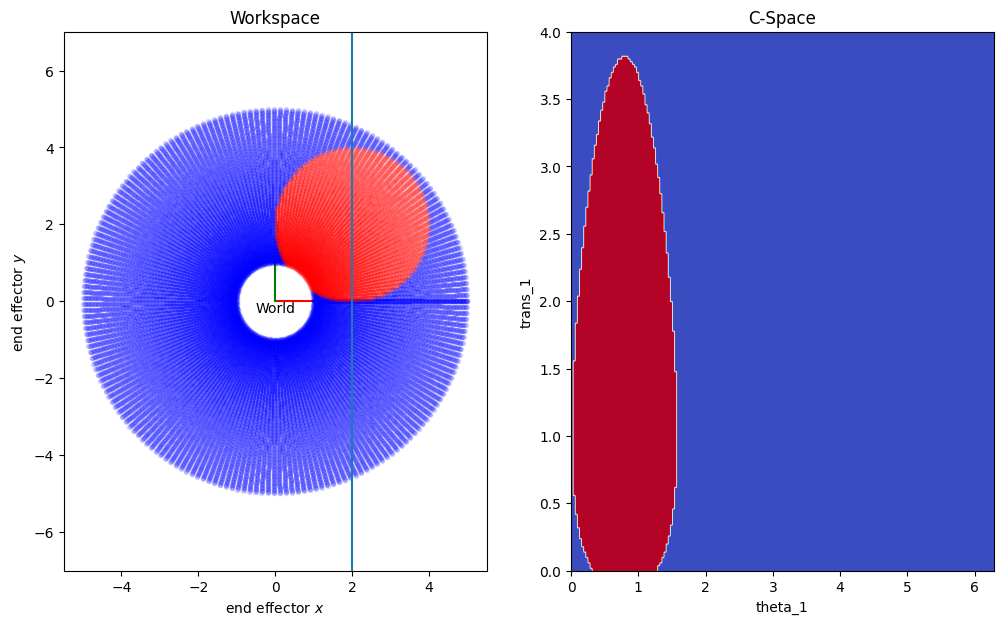

In [58]:
# minimum and maximum admissible values for theta1
theta1_range = [0, 2 * np.pi]
trans1_range = [0, 4] 
theta1s, trans1s = np.meshgrid(
    np.linspace(*theta1_range, 200), np.linspace(*trans1_range, 200)
)

endeffector_positions = []
for theta1, trans1 in zip(theta1s.flatten(), trans1s.flatten()):
    frames = fw_kinematics_new(theta1, trans1)
    endeffector_pose = frames[-1]  # Pose of the end effector
    endeffector_position = endeffector_pose @ np.array([[0, 0, 1]]).T # coordinates of endeffector
    endeffector_positions.append(endeffector_position[0:2, 0])
endeffector_positions = np.array(endeffector_positions)

radius = 2
center = np.array([2, 2])
distances = np.linalg.norm(endeffector_positions - center, axis=1)
valids = distances > radius

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 7))
plt.axis("equal")
drawf(np.eye(3), ax=ax1, name="World")
ax1.plot(
    endeffector_positions[valids, 0], endeffector_positions[valids, 1], "b.", alpha=0.1
)
ax1.plot(
    endeffector_positions[~valids, 0],
    endeffector_positions[~valids, 1],
    "r.",
    alpha=0.1,
)
ax1.set(xlabel="end effector $x$", ylabel="end effector $y$", title="Workspace")
ax1.axis("equal")
ax1.axvline(x=k)
ax2.imshow(
    valids.reshape(theta1s.shape),
    extent=theta1_range + trans1_range,
    origin="lower",
    cmap="coolwarm_r",
    aspect="auto",
)
ax2.set(xlabel="theta_1", ylabel="trans_1", title="C-Space")

- Assume that each link is a solid line connecting the frames at its endpoint.  Any configuration for which the line representing the link overlaps with a circlewith radius $d$ centered in $(x,y)$ is prohibited.

In [80]:
def line_segment_intersects_circle(p1, p2, c, r):
    dist_p1 = np.linalg.norm(p1 - c) 
    dist_p2 = np.linalg.norm(p2 - c)
    if dist_p1<r or dist_p2<r:
        return True
    if dist_p1<dist_p2:
        a,b = p1,p2
    else:
        a,b = p2,p1

    vec_ab = b - a
    vec_ac = c - a

    scalar_proj = np.dot(vec_ab, vec_ac) / np.sqrt(np.dot(vec_ab, vec_ab))
    closes_point = a
    if scalar_proj > 0:
        closes_point = a + scalar_proj * (vec_ab / np.sqrt(np.dot(vec_ab, vec_ab)))
        
    if np.linalg.norm(closes_point - c) < r:
        return True
    return False
    

In [81]:
# minimum and maximum admissible values for theta1
theta1_range = [0, 2 * np.pi]
trans1_range = [0, 4] 
theta1s, trans1s = np.meshgrid(
    np.linspace(*theta1_range, 200), np.linspace(*trans1_range, 200)
)

effector_positions = []
for theta1, trans1 in zip(theta1s.flatten(), trans1s.flatten()):
    frames = fw_kinematics_new(theta1, trans1)
    frames = [pose @ np.array([[0, 0, 1]]).T for pose in [frames[i] for i in [1,2,4]]]
    frames = [frame[0:2,0] for frame in frames]
    effector_positions.append(frames)
    #endeffector_pose = frames[-1]  # Pose of the end effector
    #endeffector_position = endeffector_pose @ np.array([[0, 0, 1]]).T # coordinates of endeffector
    #endeffector_positions.append(endeffector_position[0:2, 0])
effector_positions = np.array(effector_positions)




In [82]:
radius = 2
center = np.array([2, 2])

invalids = [line_segment_intersects_circle(frames[0], frames[1], center, radius) and 
        line_segment_intersects_circle(frames[1], frames[2], center, radius) 
        for frames in effector_positions]
invalids = np.array(invalids)
valids = ~invalids       

[Text(0.5, 0, 'theta_1'), Text(0, 0.5, 'trans_1'), Text(0.5, 1.0, 'C-Space')]

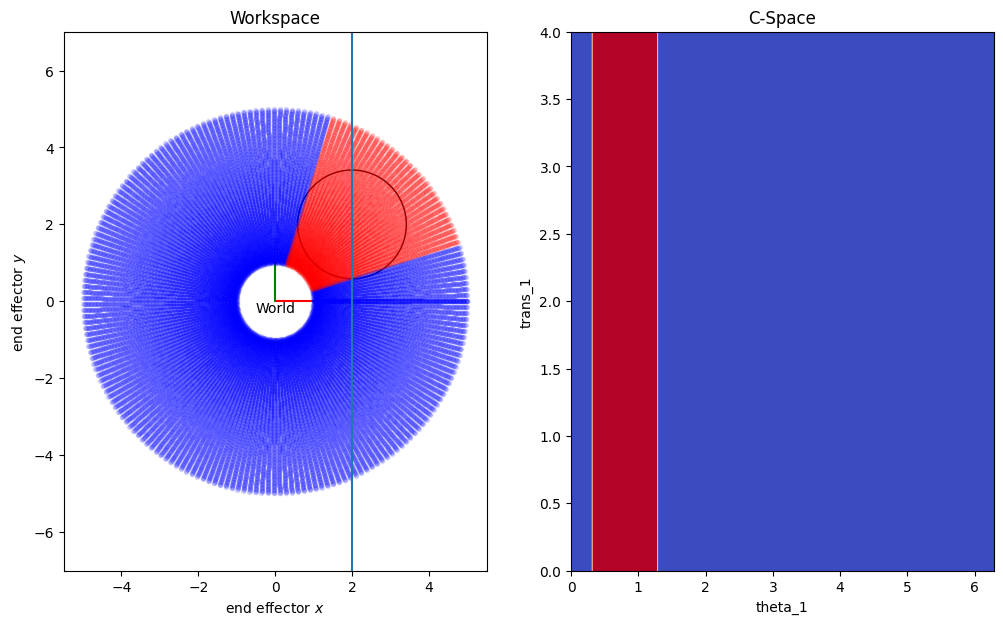

In [85]:
from matplotlib.patches import Circle
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 7))
plt.axis("equal")
drawf(np.eye(3), ax=ax1, name="World")
ax1.plot(
    endeffector_positions[valids, 0], endeffector_positions[valids, 1], "b.", alpha=0.1
)
ax1.plot(
    endeffector_positions[~valids, 0],
    endeffector_positions[~valids, 1],
    "r.",
    alpha=0.1,
)
ax1.set(xlabel="end effector $x$", ylabel="end effector $y$", title="Workspace")
ax1.axis("equal")
ax1.axvline(x=k)
circle = Circle(center, np.sqrt(2), edgecolor='black', facecolor='none')
ax1.add_patch(circle)

ax2.imshow(
    valids.reshape(theta1s.shape),
    extent=theta1_range + trans1_range,
    origin="lower",
    cmap="coolwarm_r",
    aspect="auto",
)
ax2.set(xlabel="theta_1", ylabel="trans_1", title="C-Space")